In [1]:
print("hello")

hello


In [5]:
g_api_key="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"

In [15]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from typing import Dict, Any
from dataclasses import dataclass, field
from IPython.display import Image, display

# Define the state for the graph
@dataclass
class GraphState:
    query: str = ""  # The user's query
    messages: List[Dict[str, Any]] = field(default_factory=list)  # Conversation history
    next_step: str = ""  # Routing decision
    process_complete: bool = False  # Flag to indicate if the process is complete

# Initialize the Groq model
grok_model = ChatGroq(
    api_key=g_api_key,  # Replace with your Groq API key
    model="llama-3.2-3b-preview",  # Use a valid Groq model name
)



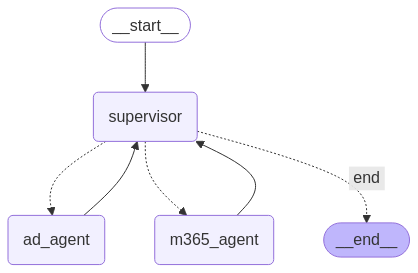

AttributeError: 'AddableValuesDict' object has no attribute 'messages'

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from typing import Dict, Any
from dataclasses import dataclass, field
from IPython.display import Image, display

# Define the state for the graph
@dataclass
class GraphState:
    query: str = ""  # The user's query
    messages: List[Dict[str, Any]] = field(default_factory=list)  # Conversation history
    next_step: str = ""  # Routing decision
    process_complete: bool = False  # Flag to indicate if the process is complete

# Initialize the Groq model
grok_model = ChatGroq(
    api_key=g_api_key,  # Replace with your Groq API key
    model="llama-3.2-3b-preview",  # Use a valid Groq model name
)

# Define the Supervisor node
def supervisor_node(state: GraphState) -> Dict[str, Any]:
    # Check if the process is complete
    if state.process_complete:
        return {"next_step": "end"}

    # If there are messages, the last one might be from an agent
    if state.messages and state.messages[-1]["role"] == "assistant":
        # Decide if the process is complete based on the agent's response
        prompt = ChatPromptTemplate.from_messages([
            ("system", "You are a supervisor. An agent has processed the query. "
                       "Based on the response, decide if the process is complete or if another agent is needed. "
                       "If the process is complete, output 'Process: complete'. "
                       "If another agent is needed, output 'Next step: [agent_name]'."),
            ("human", "Query: {query}\nResponse: {response}")
        ])
        supervisor_chain = prompt | grok_model
        result = supervisor_chain.invoke({"query": state.query, "response": state.messages[-1]["content"]})
        decision = str(result).strip()
        
        if "Process: complete" in decision:
            return {"next_step": "end", "process_complete": True}
        elif "Next step: AD Agent" in decision:
            return {"next_step": "ad_agent"}
        elif "Next step: M365 Agent" in decision:
            return {"next_step": "m365_agent"}
        else:
            return {"next_step": "end", "process_complete": True}
    else:
        # Initial routing based on the query
        prompt = ChatPromptTemplate.from_messages([
            ("system", "You are a supervisor managing two agents: AD Agent and M365 Agent. "
                       "Route the query to the appropriate agent based on the content. "
                       "If the query mentions 'AD' or 'Active Directory', route to AD Agent. "
                       "If the query mentions 'M365' or 'Microsoft 365', route to M365 Agent. "
                       "Otherwise, end the workflow. "
                       "Output your decision in the format: 'Next step: [agent_name]' or 'Next step: end'"),
            ("human", "{input}")
        ])
        supervisor_chain = prompt | grok_model
        result = supervisor_chain.invoke({"input": state.query})
        decision = str(result).strip()

        if "Next step: AD Agent" in decision:
            return {"next_step": "ad_agent"}
        elif "Next step: M365 Agent" in decision:
            return {"next_step": "m365_agent"}
        else:
            return {"next_step": "end", "process_complete": True}

# Define the AD Agent node
def ad_agent_node(state: GraphState) -> Dict[str, Any]:
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are an Active Directory (AD) expert agent. Process the query and provide a response."),
        ("human", "{input}")
    ])
    ad_chain = prompt | grok_model
    result = ad_chain.invoke({"input": state.query})
    response = f"AD Agent processed: {str(result)}"
    return {"messages": state.messages + [{"role": "assistant", "content": response}]}

# Define the M365 Agent node
def m365_agent_node(state: GraphState) -> Dict[str, Any]:
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a Microsoft 365 (M365) expert agent. Process the query and provide a response."),
        ("human", "{input}")
    ])
    m365_chain = prompt | grok_model
    result = m365_chain.invoke({"input": state.query})
    response = f"M365 Agent processed: {str(result)}"
    return {"messages": state.messages + [{"role": "assistant", "content": response}]}

# Define the routing logic for the supervisor
def supervisor_router(state: GraphState) -> str:
    return state.next_step if state.next_step else "end"

# Create and configure the graph
builder = StateGraph(GraphState)

# Add nodes
builder.add_node("supervisor", supervisor_node)
builder.add_node("ad_agent", ad_agent_node)
builder.add_node("m365_agent", m365_agent_node)

# Add edges
builder.add_edge(START, "supervisor")  # Start -> Supervisor
builder.add_conditional_edges(
    "supervisor",
    supervisor_router,
    {
        "ad_agent": "ad_agent",
        "m365_agent": "m365_agent",
        "end": END
    }
)
builder.add_edge("ad_agent", "supervisor")  # AD Agent -> Supervisor
builder.add_edge("m365_agent", "supervisor")  # M365 Agent -> Supervisor

# Compile the graph
graph = builder.compile()

# Visualize the graph
try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    print(f"Visualization failed: {e}")

# Test the graph with a sample input
initial_input = {
    "query": "I need help with Active Directory",
    "messages": [{"role": "user", "content": "I need help with Active Directory"}]
}
result = graph.invoke(initial_input)
print("Conversation History:", result["messages"])
